In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from quetzal.model import stepmodel
from quetzal.io import excel
import matplotlib.pyplot as plt

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


In [3]:
model_path = '../model/' + scenario + '/'
input_path = '../input/'
output_path = '../output/'

# Destination choice Logit model

## Needs zone attributes and composite cost

## Saves probabilities of destination choice

`quetzal` is designed to model the mode choice as discrete choice model. Therefore some columns and labels of the distance choice model must be renamed in order to use the quetzal functions.

In [4]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Transport demand segments
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = ['commuting', 'business', 'education', 'buy/execute', 'leisure', 'accompany']
p_dict = dict(zip(purposes, [1,2,3,4,6,7]))

In [6]:
# Load model zones and data
sm = stepmodel.read_json(model_path + 'de_zones')
pois = pd.read_csv(input_path + 'spatial_num_pois_raw.csv', index_col='index')
cats = pd.read_excel(input_path + 'spatial_OSM_POI_list.xlsx', sheet_name='categories')
cats['label'] = (cats['key'] + ' ' + cats['value'].fillna('')).str.strip()
cc_inter = pd.read_csv(output_path + scenario + '/mode_choice_od_composite_cost.csv', index_col=['origin', 'destination'])
cc_inner = pd.read_csv(input_path + 'inner-zonal_cc.csv', index_col='Unnamed: 0')
distances = pd.read_csv(output_path + 'distances_centroids.csv', index_col=['origin', 'destination'])['length'] # km

In [7]:
# Load employment data
employment = pd.read_csv('../input_static/spatial_employed_persons_2017_eurostat.csv', encoding='latin-1')
employment['Value'] = (pd.to_numeric(employment['Value'].str.replace(',', '')) * 1000).astype(int)
# Also, load NUTS-names
nuts = gpd.read_file("../input_static/spatial_NUTS_RG_01M_2016_4326.geojson")
nuts = nuts[(nuts["CNTR_CODE"]=="DE") & (nuts["LEVL_CODE"]==3)]
# Map differing names of zones to names in employment data
name_dict = {'Burgenlandkreis (DE)': 'Burgenlandkreis',
             'Dillingen an der Donau': 'Dillingen a.d. Donau',
             'Mühldorf am Inn': 'Mühldorf a. Inn',
             'Neumarkt in der Oberpfalz': 'Neumarkt i. d. OPf.',
             'Neustadt an der Aisch-Bad Windsheim': 'Neustadt a. d. Aisch-Bad Windsheim',
             'Neustadt an der Waldnaab': 'Neustadt a. d. Waldnaab',
             'Pfaffenhofen an der Ilm': 'Pfaffenhofen a. d. Ilm',
             'Weiden in der Oberpfalz, Kreisfreie Stadt': 'Weiden i. d. Opf, Kreisfreie Stadt',
             'Wunsiedel im Fichtelgebirge': 'Wunsiedel i. Fichtelgebirge'}
employment['GEO'].replace(name_dict, inplace=True)
zone_dict = employment.set_index('GEO')['Value'].to_dict()
name_dict = nuts.set_index('NUTS_ID')['NUTS_NAME'].to_dict()
sm.zones['employment'] = sm.zones['NUTS_ID'].map(name_dict).map(zone_dict) * sm.zones['pop_share']

### Build a destination choice LoS table

Use number of POIs from OSM and generalised composite cost from mode choice, as well as inner-zonal GCC calculated in the same fashion from survey data.

In [8]:
# Create OD stack
sm.los = sm.zones[['FID', 'urbanisation']].merge(
    sm.zones[['FID', 'urbanisation', 'population', 'area', 'employment']],
    how='cross', suffixes=('_o', '_d'))
sm.los.rename(columns={'FID_o':'origin', 'FID_d':'destination',
                       'population':'population_d', 'area': 'area_d',
                       'employment': 'employment_d'}, inplace=True)

In [9]:
# Assign OD distances
sm.los['distance'] = sm.los.set_index(['origin', 'destination']).index.map(
    distances).fillna(np.inf)

In [10]:
# Fill POI values
'''for p, p_m in zip(['education', 'shopping', 'leisure'], ['education', 'buy/execute', 'leisure']):
    for suffix in ['_many', '_few']:
        sm.los[p_m+suffix+'_d'] = sm.los['destination'].map(attr[p+suffix].to_dict()) + 1
sm.los['accompany_d'] = sm.los['destination'].map(attr['accompany'].to_dict()) + 1'''
for category, columns in cats.loc[cats['category'].notna()
                                 ].groupby('category').agg(
                                {'label': list})['label'].items():
    sm.los[category] = sm.los['destination'].map(pois[columns].sum(axis=1)) + 1

In [11]:
# Add one to employment, so that it is 0 nowhere
sm.los['employment_d'] += 1

In [12]:
# Add GCC
for seg in segments:
    col = str((seg, 'gcc'))
    # Inter-zonal
    sm.los[col] = sm.los.set_index(['origin', 'destination']).index.map(cc_inter[seg])
    # Fill missing values with maximums
    fill = sm.los.loc[(sm.los[col].notna()) & (sm.los['origin']!=sm.los['destination']), col].max()
    sm.los.loc[(sm.los[col].isna()) & (sm.los['origin']!=sm.los['destination']), col] = fill
    # Inner-zonal is the rest
    sm.los.loc[sm.los[col].isna(), col] = sm.los.loc[sm.los[col].isna(), 'origin'].map(cc_inner[seg])
    # Fill missing zones with meansfor inner-zonal CC
    sm.los[col] = sm.los[col].fillna(sm.los.loc[sm.los['origin']==sm.los['destination'], col].mean())

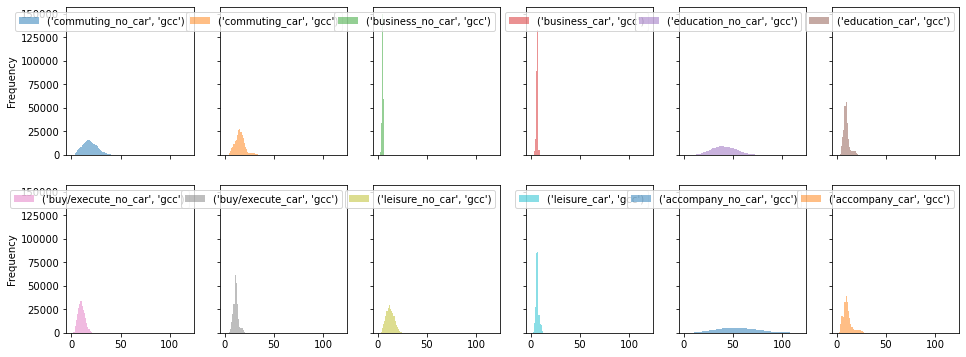

In [13]:
# visualise the the composite cost
cols = [str((s, 'gcc')) for s in segments]
fig, ax = plt.subplots(ncols=int(len(segments)/2), nrows=2, sharex='col', sharey='all', figsize=(16,6))
sm.los.set_index('destination')[cols].sample(int(len(sm.los)/20)).plot(
    subplots=True, figsize=(2,3), kind='hist', bins=100, alpha=.5, ax=ax)
print('')

In [14]:
# 'route type', which denotes the mode, corresponds to the column of choice
sm.los['route_type'] = sm.los['destination'].copy()
sm.los['route_types'] = [(i,) for i in sm.los['route_type']]
# The choice (route_type) will be evalated for every OD pair
sm.los['destination'] = 'DUMMY'

In [15]:
sm.los = sm.los.loc[sm.los.notna().all(axis=1)]
len(sm.los)

4950625

In [16]:
# Drop inner-zonal rows, if calibration is only inter-zonal
sm.los = sm.los.loc[sm.los['origin']!=sm.los['route_type']]
len(sm.los)

4948400

In [17]:
sm.los.sample()

,origin,urbanisation_o,destination,urbanisation_d,population_d,area_d,employment_d,distance,childcare,daily_leisure,...,"('education_no_car', 'gcc')","('education_car', 'gcc')","('buy/execute_no_car', 'gcc')","('buy/execute_car', 'gcc')","('leisure_no_car', 'gcc')","('leisure_car', 'gcc')","('accompany_no_car', 'gcc')","('accompany_car', 'gcc')",route_type,route_types
1041857,DE229_6,3,DUMMY,2,14883,252.57,7337.04692,216.0,7,58,...,29.597411,6.83936,6.582837,8.883338,8.807688,5.413581,35.22757,5.740749,DE23A_1,"(DE23A_1,)"


### Define model attributes and parameters for step_logit function

In [18]:
# decide whether to run nested logit model or multinomial logit model
nested = False # Nested Logit model with urbanisation degrees
daly1982 = True # Utility function not linear-in-the-parameters as in Daly (1982)

# Load estimation results, choose right file for variation!
excel = pd.ExcelFile(input_path + 'estimation_results_dest_bounds_inter.xls')
car_name = ['_no_car', '_car']
params_est = {p+car_name[c]: excel.parse(str(p_dict[p])+'_'+str(c)).set_index('Unnamed: 0')
              for p in purposes for c in [0,1]}

In [19]:
# set the nested structure for each segment, must be the same as in the estimation
destinations = list(sm.zones.index)
segs = segments + ['root']
if nested:
    urban_dict = sm.zones['urbanisation'].to_dict()
    col = ['urban'+str(urban_dict[d]) for d in destinations] + ['root']*3 + [np.nan]
    index = destinations + ['urban1', 'urban2', 'urban3', 'root']
else: 
    col = ['root']*len(destinations) + [np.nan]
    index = destinations + ['root']
nests = pd.DataFrame(index=index,
                     data={s: col for s in segments})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
route_type,,,,,,,,,,,,
DE111_0,root,root,root,root,root,root,root,root,root,root,root,root
DE112_0,root,root,root,root,root,root,root,root,root,root,root,root
DE112_1,root,root,root,root,root,root,root,root,root,root,root,root
DE112_2,root,root,root,root,root,root,root,root,root,root,root,root
DE112_3,root,root,root,root,root,root,root,root,root,root,root,root
...,...,...,...,...,...,...,...,...,...,...,...,...
DEG0P_6,root,root,root,root,root,root,root,root,root,root,root,root
outer_1,root,root,root,root,root,root,root,root,root,root,root,root
outer_2,root,root,root,root,root,root,root,root,root,root,root,root


In [20]:
# phi/theta values for each choice option and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=destinations, data={seg: 1 for seg in segments})
sm.logit_scales.loc['root'] = [1 for seg in segments]
# For the nested structure
if nested: 
    sm.logit_scales.loc['urban1'] = [1 / params_est[s].loc['mu_u1', 'Value'] for s in segments]
    sm.logit_scales.loc['urban2'] = [1 / params_est[s].loc['mu_u2', 'Value'] for s in segments]
    sm.logit_scales.loc['urban3'] = [1 / params_est[s].loc['mu_u3', 'Value'] for s in segments]
sm.logit_scales.columns.name = 'segment'
sm.logit_scales.index.name = 'route_type'
sm.logit_scales

segment,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
route_type,,,,,,,,,,,,
DE111_0,1,1,1,1,1,1,1,1,1,1,1,1
DE112_0,1,1,1,1,1,1,1,1,1,1,1,1
DE112_1,1,1,1,1,1,1,1,1,1,1,1,1
DE112_2,1,1,1,1,1,1,1,1,1,1,1,1
DE112_3,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
DEG0P_6,1,1,1,1,1,1,1,1,1,1,1,1
outer_1,1,1,1,1,1,1,1,1,1,1,1,1
outer_2,1,1,1,1,1,1,1,1,1,1,1,1


In [21]:
# As there are no alternative specific costants in the utility formulation, 
# the initial values are set to 0
sm.mode_utility = pd.DataFrame(index=destinations, data={seg: 0 for seg in segments})
if nested:
    sm.mode_utility.loc['urban1'] = 0
    sm.mode_utility.loc['urban2'] = 0
    sm.mode_utility.loc['urban3'] = 0
sm.mode_utility.columns.name = 'segment'
sm.mode_utility.columns.name = 'route_type'

In [22]:
# Prepare attraction columns per purpose
# quetzal can only work with linear-in-the-parameters utility functions,
# but destination choice with POI values requires logarithmic formulations.
# See estimation notebook for utility formulation and scaling
for car in [0,1]:
    def get_b(p, b):
        return max(0, params_est[p+car_name[car]].loc[b, 'Value'])
    
    if daly1982:
        sm.los['commuting'+car_name[car]+'_attr'] = np.log(sm.los['employment_d'])
        sm.los['business'+car_name[car]+'_attr'] = np.log(sm.los['employment_d'])
        sm.los['education'+car_name[car]+'_attr'] = \
            np.log(sm.los['childcare'] * get_b('education', 'b_edu1') 
                   + sm.los['school'] * get_b('education', 'b_edu2')
                   + sm.los['higher_education'])
        sm.los['buy/execute'+car_name[car]+'_attr'] = \
            np.log(sm.los['shop'] * get_b('buy/execute', 'b_shop1')
                   + sm.los['medical'] * get_b('buy/execute', 'b_shop2')
                   + sm.los['special_shop'])
        sm.los['leisure'+car_name[car]+'_attr'] = \
            np.log(sm.los['daily_leisure'] * get_b('leisure', 'b_leisure1')
                   + sm.los['holiday'] * get_b('leisure', 'b_leisure2')
                   + sm.los['occasional_leisure'])
        sm.los['accompany'+car_name[car]+'_attr'] = \
            np.log(sm.los['medical'] * get_b('accompany', 'b_accom1')
                   + sm.los['school'] * get_b('accompany', 'b_accom2')
                   + sm.los['childcare'])

    else:
        sm.los['commuting'+car_name[car]+'_attr'] = \
            np.log(sm.los['employment_d']) * get_b('commuting', 'b_empl')
        sm.los['business'+car_name[car]+'_attr'] = \
            np.log(sm.los['employment_d']) * get_b('business', 'b_empl')
        sm.los['education'+car_name[car]+'_attr'] = \
            np.log(sm.los['higher_education']) * get_b('education', 'b_edu1') \
            + np.log(sm.los['school']) * get_b('education', 'b_edu2') \
            + np.log(sm.los['childcare']) * get_b('education', 'b_edu3')
        sm.los['buy/execute'+car_name[car]+'_attr'] = \
            np.log(sm.los['medical']) * get_b('buy/execute', 'b_shop1') \
            + np.log(sm.los['shop']) * get_b('buy/execute', 'b_shop2') \
            + np.log(sm.los['special_shop']) * get_b('buy/execute', 'b_shop3')
        sm.los['leisure'+car_name[car]+'_attr'] = \
            np.log(sm.los['holiday']) * get_b('leisure', 'b_leisure1') \
            + np.log(sm.los['daily_leisure']) * get_b('leisure', 'b_leisure2') \
            + np.log(sm.los['occasional_leisure']) * get_b('leisure', 'b_leisure3')
        sm.los['accompany'+car_name[car]+'_attr'] = \
            np.log(sm.los['medical']) * get_b('accompany', 'b_accom1') \
            + np.log(sm.los['school']) * get_b('accompany', 'b_accom2') \
            + np.log(sm.los['childcare']) * get_b('accompany', 'b_accom3')


In [23]:
# Generate columns for zone quality attributes
for p in purposes:
    for car in [0,1]:
        sm.los[p+car_name[car]+'_pop'] = \
            np.maximum(0, np.log(sm.los['population_d'] / sm.los['area_d']))

In [24]:
# Generate column for non-linear distance
sm.los['distance2'] = np.power(sm.los['distance'], 2)

In [25]:
# Columns of attributes in los table for destination choice
quality_cols = [s+'_pop' for s in segments]
quantity_cols = [s+'_attr' for s in segments]
gcc_cols = [str((s, 'gcc')) for s in segments]

In [26]:
# Beta parameters from calibration data
sm.utility_values = pd.DataFrame({seg: [0]*len(quality_cols+quantity_cols+gcc_cols)
                                  for seg in segments}, index=quality_cols+quantity_cols+gcc_cols)
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
for a,s in zip(quality_cols, segments):
    sm.utility_values.loc[a, s] = params_est[s].loc['b_pop', 'Value']
for a,s in zip(quantity_cols, segments):
    sm.utility_values.loc[a, s] = params_est[s].loc['b_size', 'Value'] if daly1982 else 1
for a,s in zip(gcc_cols, segments):
    sm.utility_values.loc[a, s] = params_est[s].loc['b_gc', 'Value']
if 'b_dist' in params_est[segments[0]].index:
    sm.utility_values.loc['distance'] = [params_est[s].loc['b_dist', 'Value'] for s in segments]
sm.utility_values.loc['distance2'] = [params_est[s].loc['b_dist2', 'Value']
                                      if 'b_dist2' in params_est[s].index else 0
                                      for s in segments]
sm.utility_values.loc['urbanisation_d'] = [params_est[s].loc['b_urban', 'Value']
                                           if 'b_urban' in params_est[s].index else 0
                                           for s in segments]

sm.utility_values.columns.name = 'segment'
sm.utility_values.index.name = 'value'
sm.utility_values

segment,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
value,,,,,,,,,,,,
commuting_no_car_pop,0.165570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
commuting_car_pop,0.000000,0.357393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
business_no_car_pop,0.000000,0.000000,0.206337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
business_car_pop,0.000000,0.000000,0.000000,-0.076496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
education_no_car_pop,0.000000,0.000000,0.000000,0.000000,1.110669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
education_car_pop,0.000000,0.000000,0.000000,0.000000,0.000000,0.378296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
buy/execute_no_car_pop,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.381317,0.000000,0.000000,0.000000,0.000000,0.000000
buy/execute_car_pop,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269338,0.000000,0.000000,0.000000,0.000000
leisure_no_car_pop,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.366457,0.000000,0.000000,0.000000


## Choice

In [27]:
sm.segments = segments
# calculate utilities
sm.analysis_mode_utility(how='main')

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:55<00:00,  4.60s/it]


In [28]:
# Run the logit model to calculate probabilities
sm.step_logit(keep_od_tables=True, workers=4, decimals=10, nchunks=12)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [03:41<00:00, 18.44s/it]


In [29]:
sm.probabilities.head(3)

route_type,origin,destination,segment,root,DEF07_99,outer_2,outer_1,DEG0P_6,DEG0P_5,DEG0P_4,...,DE113_1,DE113_0,DE112_6,DE112_5,DE112_4,DE112_3,DE112_2,DE112_1,DE112_0,DE111_0
0,DE115_0,DUMMY,accompany_car,1,1.181352e-08,0.0,1.381299e-07,4.414988e-10,2.343916e-09,1.302194e-09,...,0.044314,0.021410,0.007704,0.032172,0.006590,0.003484,0.014078,0.002611,0.015579,0.210569
1,DE115_0,DUMMY,accompany_no_car,1,9.642659e-07,0.0,3.187999e-06,8.838534e-07,1.587974e-06,3.301135e-06,...,0.031674,0.020199,0.006983,0.012591,0.009469,0.006857,0.012423,0.008630,0.024382,0.154088
2,DE115_0,DUMMY,business_car,1,1.132427e-09,0.0,7.417632e-11,1.763895e-06,5.415443e-06,3.243920e-06,...,0.036646,0.015720,0.004868,0.016821,0.006960,0.004593,0.009033,0.005001,0.021726,0.175046


In [30]:
sm.utilities.head(3)

route_type,origin,destination,segment,root,DEF07_99,outer_2,outer_1,DEG0P_6,DEG0P_5,DEG0P_4,...,DE113_1,DE113_0,DE112_6,DE112_5,DE112_4,DE112_3,DE112_2,DE112_1,DE112_0,DE111_0
0,DE115_0,DUMMY,accompany_car,5.438278,-12.815743,-inf,-10.356794,-16.102568,-14.433165,-15.020937,...,2.321820,1.594365,0.572264,2.001624,0.416072,-0.221180,1.175169,-0.509591,1.276420,3.880334
1,DE115_0,DUMMY,accompany_no_car,4.441074,-9.410825,-inf,-8.215043,-9.497901,-8.911977,-8.180170,...,0.988825,0.538935,-0.523175,0.066269,-0.218704,-0.541432,0.052863,-0.311456,0.727149,2.570844
2,DE115_0,DUMMY,business_car,9.088526,-11.510377,-inf,-14.236050,-4.159460,-3.037730,-3.550202,...,5.782061,4.935734,3.763472,5.003413,4.121000,3.705306,4.381659,3.790338,5.259261,7.345819


In [31]:
sm.los.head(3)

,origin,urbanisation_o,destination,urbanisation_d,population_d,area_d,employment_d,distance,childcare,daily_leisure,...,"(business_no_car, probability)","(business_car, probability)","(education_no_car, probability)","(education_car, probability)","(buy/execute_no_car, probability)","(buy/execute_car, probability)","(leisure_no_car, probability)","(leisure_car, probability)","(accompany_no_car, probability)","(accompany_car, probability)"
1,DE111_0,1,DUMMY,1,136175,132.87,79748.175476,22.0,95,251,...,0.020495,0.054283,0.046422,0.076051,0.043648,0.067723,NaN,0.056732,0.049332,0.042968
2,DE111_0,1,DUMMY,2,68243,154.02,39965.652073,40.0,55,128,...,0.004814,0.011658,0.007207,0.006203,0.014279,0.007709,NaN,0.009157,0.017888,0.007168
3,DE111_0,1,DUMMY,2,37642,74.32,22045.010863,34.0,28,87,...,0.003081,0.013930,0.009196,0.013184,0.011515,0.018106,NaN,0.014994,0.013092,0.016790


In [32]:
# Check if probabilities sum up to one
sm.probabilities.set_index(['segment', 'origin'], drop=True).drop(
    ['root', 'destination', 'urban1', 'urban2', 'urban3'], axis=1, errors='ignore'
).sum(axis=1).describe()

count    26592.000000
mean         0.916667
std          0.276391
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

In [33]:
sm.probabilities.loc[sm.probabilities[list(sm.zones.index)].sum(axis=1)<0.999, 'segment'].unique()

array(['leisure_no_car'], dtype=object)

## Save model

In [34]:
sm.utilities.reset_index(drop=True, inplace=True)
sm.probabilities.reset_index(drop=True, inplace=True)
sm.to_zippedpickles(model_path + 'de_destination_choice', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities'])

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 15/15 [01:22<00:00,  5.47s/it]


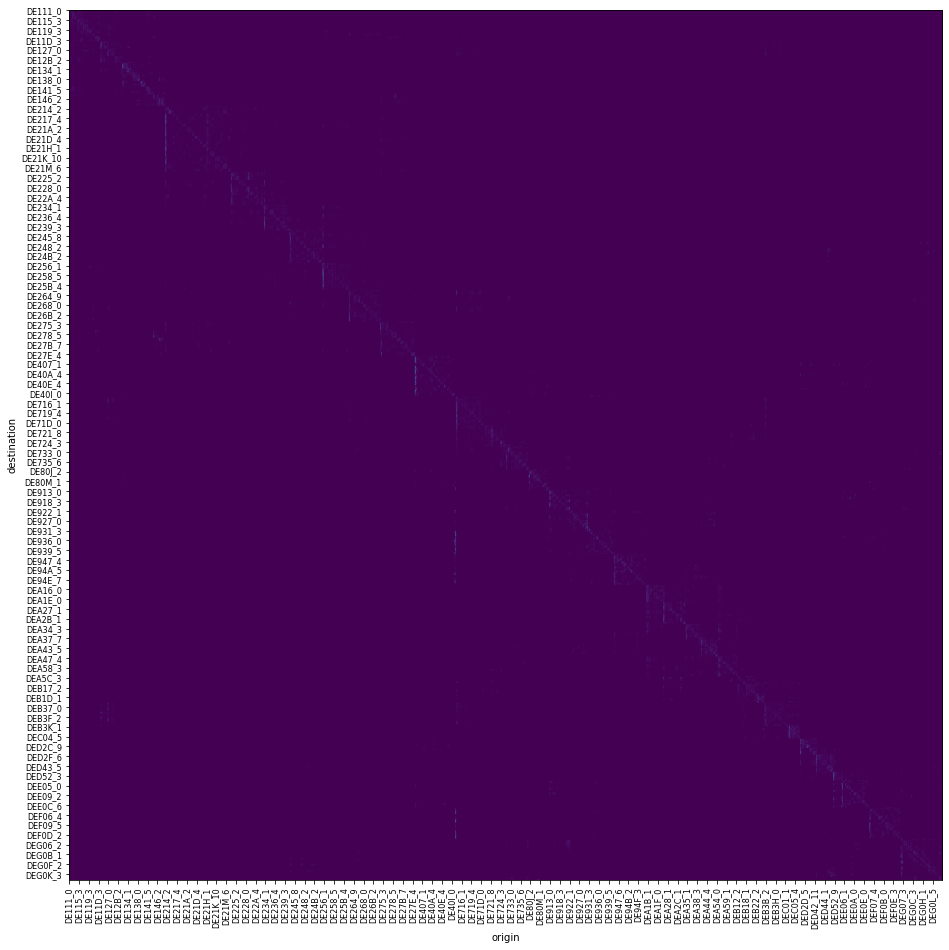

In [35]:
show = segments[9]
matrix = sm.probabilities.set_index(['segment', 'origin'], drop=True).drop(
    ['root', 'destination'], axis=1).sort_index(axis=1).loc[show].sort_index(axis=0)
fig, ax = plt.subplots(figsize=(16,16))
xlabels = list(matrix.index)
ylabels = list(matrix.columns)
label_step = 25
ax.imshow(matrix.values)
ax.set_xticks(range(0, len(xlabels), label_step), labels=xlabels[::label_step], fontsize=8, rotation=90)
ax.set_yticks(range(0, len(ylabels), label_step), labels=ylabels[::label_step], fontsize=8)
ax.set_xlabel('origin')
ax.set_ylabel('destination')
print('')